%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(15,3)})

import seaborn as sns
sns.set(style='whitegrid')

import bambi as bmb, pandas as pd, numpy as np, arviz as az, pymc as pm
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [1]:
%load_ext rpy2.ipython


In [2]:
%%R 
library(rethinking)

Loading required package: rstan
Loading required package: StanHeaders

rstan version 2.26.16 (Stan version 2.26.1)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

Loading required package: cmdstanr
This is cmdstanr version 0.5.3
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Loading required package: parallel
rethinking (Version 2.31)

Attaching package: ‘rethinking’

The following object is masked from ‘package:rstan’:

    stan

The following object is masked from ‘package:stats’:

    rstudent



# Grid Approximation

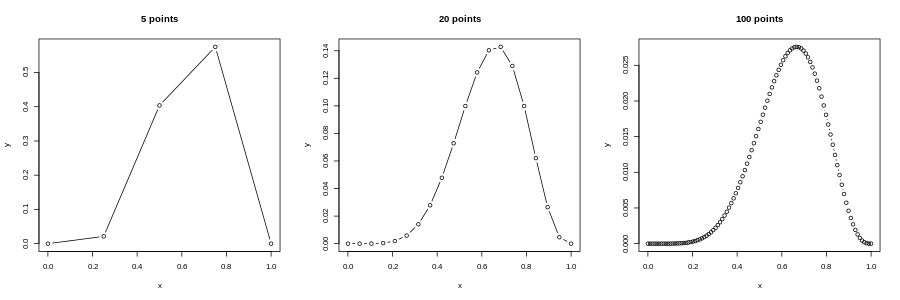

In [3]:
%%R  -w 900 -h 300

hcc <- function(N){
    
    p.grid <- seq(0,1,length.out=N)
    prior  <- rep(1,N)
    likelihood <- dbinom(6,9, p.grid)
    posterior.raw <-  prior*likelihood
    posterior <- posterior.raw/sum(posterior.raw)    
    return (list(x=p.grid, y=posterior, main=paste(N, "points")))
    
}

par(mfrow=c(1,3))
with(hcc(N=5),  plot(x,y,type='b',main=main) )
with(hcc(N=20) , plot(x,y,type='b',main=main),  )
with(hcc(N=100) , plot(x,y,type='b',main=main),  )



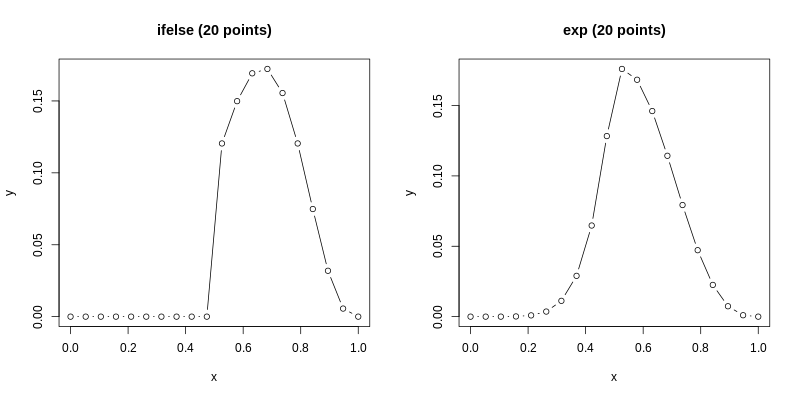

In [4]:
%%R  -w 800 -h 400

my.workspace <- function(N, func, msg){
    
    p.grid <- seq(0,1,length.out=N)
    prior  <- func(p.grid)
                      
    likelihood <- dbinom(6,9, p.grid)
    posterior.raw <-  prior*likelihood
    posterior <- posterior.raw/sum(posterior.raw)    
    
    return (list(x=p.grid, y=posterior, main=sprintf('%s (%d points)',msg,N)))
    
}

par(mfrow=c(1,2))

func=\(grid) ifelse(grid<0.5,0,1)
with(my.workspace(N=20, func=func, msg='ifelse'),  plot(x,y,type='b',main=main) )

func=\(grid) exp(-5*abs(grid - 0.5))
with(my.workspace(N=20, func=func, msg='exp') ,  plot(x,y,type='b',main=main) )

# Quadratic Approximation

In [5]:
%%R 
globe.qa <- quap(
    alist(
        # binomial likelihood
        W ~ dbinom( W+L ,p) , 
        # uniform prior
        p ~ dunif(0,1)    
    ) ,
    data=list(W=6,L=3) 
)
precis( globe.qa )

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


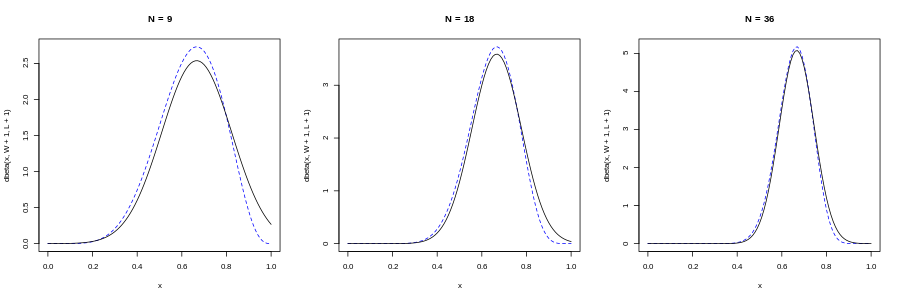

In [6]:
%%R  -w 900 -h 300

my.workspace <- function(W,L){
    
    globe.qa <- quap(
        alist(
            # binomial likelihood
            W ~ dbinom( W+L ,p) , 
            # uniform prior
            p ~ dunif(0,1)    
        ) ,
        data=list(W=W,L=L) 
    )
    ans <- precis( globe.qa )
    
    curve( dbeta( x , W+1 , L+1 ) , from=0 ,lty=2, to=1, main=sprintf('N = %d',W+L), col='blue' )
    curve( dnorm( x , ans$mean , ans$sd ) , add=TRUE )
    
}



par(mfrow=c(1,3))

my.workspace(W=6,L=3)

my.workspace(W=12,L=6)

my.workspace(W=24,L=12)



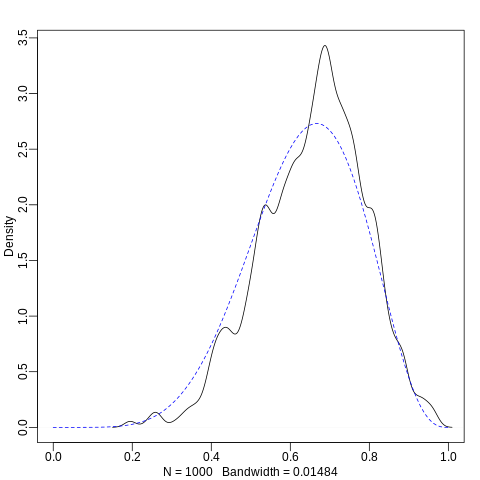

In [7]:
%%R 

n_samples <- 1000
p <- rep( NA , n_samples )
p[1] <- 0.5
W <- 6
L <- 3
for ( i in 2:n_samples ) {
    p_new <- rnorm( 1 , p[i-1] , 0.1 )
    if ( p_new < 0 ) p_new <- abs( p_new )
    if ( p_new > 1 ) p_new <- 2 - p_new
    q0 <- dbinom( W , W+L , p[i-1] )
    q1 <- dbinom( W , W+L , p_new )
    p[i] <- ifelse( runif(1) < q1/q0 , p_new , p[i-1] )
}

dens( p , xlim=c(0,1) )
curve( dbeta( x , W+1 , L+1 ) , lty=2 , add=TRUE , col='blue' )